<a href="https://colab.research.google.com/github/Cham0703/DU_AN_SPAM/blob/main/main_email_detechtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code 1

Đã đoán encoding: Windows-1252
Số lượng ham/spam:
label
ham     4825
spam     747
Name: count, dtype: int64


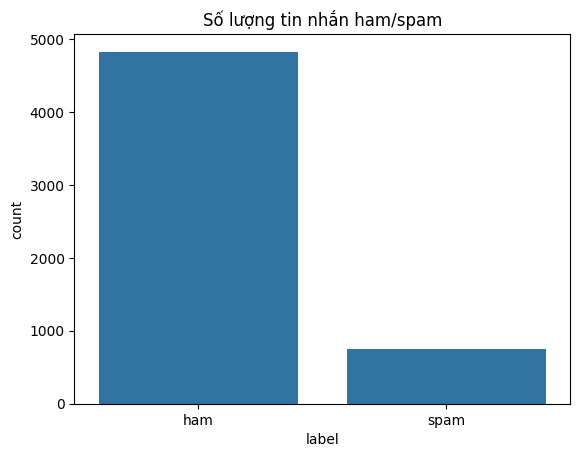

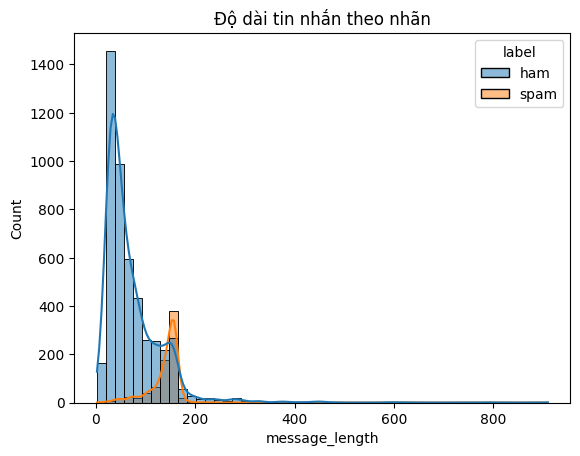

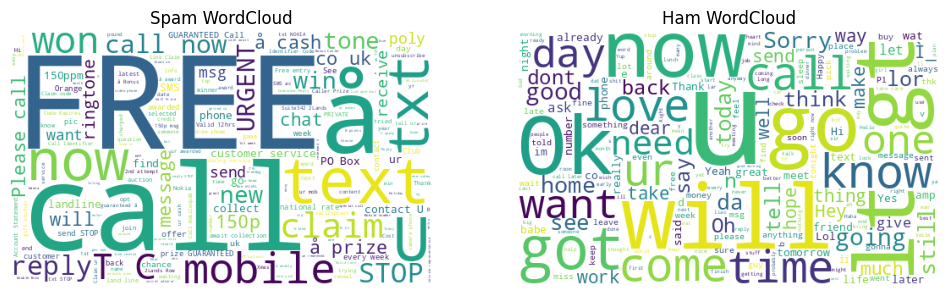

  label                                    cleaned_message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry wkly comp win fa cup final tkts st ...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
# 🧾 BƯỚC 1: Đọc file từ ổ đĩa
duong_dan = "spam.csv"
# Tự động phát hiện encoding của file để tránh lỗi khi đọc
with open(duong_dan, "rb") as f:
    result = chardet.detect(f.read(10000))  # Đọc thử 10.000 byte
    encoding = result['encoding']
    print(f"Đã đoán encoding: {encoding}")
# Đọc dữ liệu và chuẩn hóa cột
df = pd.read_csv(duong_dan, encoding=encoding)
df = df[['v1', 'v2']]                    # Lấy 2 cột cần thiết
df.columns = ['label', 'message']       # Đặt tên cột rõ ràng
# 📊 BƯỚC 2: Khám phá dữ liệu (EDA)
# Thống kê số lượng ham/spam
print("Số lượng ham/spam:")
print(df['label'].value_counts())
# Vẽ biểu đồ cột số lượng
sns.countplot(data=df, x='label')
plt.title("Số lượng tin nhắn ham/spam")
plt.show()
# Tính độ dài tin nhắn
df['message_length'] = df['message'].apply(len)
# Vẽ biểu đồ phân bố độ dài tin nhắn
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Độ dài tin nhắn theo nhãn")
plt.show()
# ☁️ BƯỚC 3: Tạo WordCloud
spam_text = ' '.join(df[df['label'] == 'spam']['message'])
ham_text = ' '.join(df[df['label'] == 'ham']['message'])
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300, background_color='white').generate(spam_text))
plt.axis("off")
plt.title("Spam WordCloud")
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300, background_color='white').generate(ham_text))
plt.axis("off")
plt.title("Ham WordCloud")
plt.show()
# 🧹 BƯỚC 4: Làm sạch tin nhắn
# Đường dẫn đến file spam.csv của bạn
duong_dan = "spam.csv"
# Phát hiện encoding để tránh lỗi Unicode
with open(duong_dan, "rb") as f:
    encoding = chardet.detect(f.read())['encoding']
# Đọc dữ liệu và đổi tên cột
df = pd.read_csv(duong_dan, encoding=encoding)[['v1', 'v2']]
df.columns = ['label', 'message']
# Tải stopwords nếu chưa có
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Hàm làm sạch văn bản
def clean_message(msg):
    msg = msg.lower()                              # Chuyển sang chữ thường
    msg = re.sub(r'\d+', '', msg)                 # Xoá chữ số
    msg = re.sub(r'[^\w\s]', '', msg)             # Xoá dấu câu
    words = msg.split()                           # Tách từ
    words = [w for w in words if w not in stop_words]  # Bỏ stop words
    return ' '.join(words)
# Tạo cột mới chứa tin nhắn đã làm sạch
df['cleaned_message'] = df['message'].apply(clean_message)
# Chỉ giữ lại hai cột yêu cầu: nhãn và tin nhắn đã làm sạch
df_output = df[['label', 'cleaned_message']]
# Hiển thị 5 dòng đầu để kiểm tra
print(df_output.head())

Code 2

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

duong_dan = "spam.csv"

# BƯỚC 1: Chuyển đổi nhãn sang dạng số
# Chuyển 'ham' thành 0, 'spam' thành 1
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# In ra để kiểm tra
print("Số lượng mẫu theo nhãn số:")
print(df['label_num'].value_counts())

# BƯỚC 2: Chuyển đổi tin nhắn thành đặc trưng số
# Sử dụng CountVectorizer (Mô hình Bag of Words)
count_vectorizer = CountVectorizer(max_features=5000)  # Giới hạn 5000 từ phổ biến nhất
X_count = count_vectorizer.fit_transform(df['cleaned_message'])

# Sử dụng TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_message'])

# In ra kích thước của dữ liệu sau khi chuyển đổi
print(f"Kích thước dữ liệu CountVectorizer: {X_count.shape}")
print(f"Kích thước dữ liệu TF-IDF: {X_tfidf.shape}")

# BƯỚC 3: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# Sử dụng cả hai loại đặc trưng để so sánh
# Sử dụng CountVectorizer
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(
    X_count, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# Sử dụng TF-IDF
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num']
)

# BƯỚC 4: Lưu từ vựng để sử dụng sau này
count_vocab = count_vectorizer.get_feature_names_out()
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# In ra thông tin về tập huấn luyện và kiểm tra
print("\nThông tin về bộ dữ liệu đã chia:")
print(f"Số lượng mẫu huấn luyện: {X_count_train.shape[0]}")
print(f"Số lượng mẫu kiểm tra: {X_count_test.shape[0]}")
print(f"Tỷ lệ spam trong tập huấn luyện: {y_count_train.mean()*100:.2f}%")
print(f"Tỷ lệ spam trong tập kiểm tra: {y_count_test.mean()*100:.2f}%")


output_summary = {
    'CountVectorizer': {
        'X_train shape': X_count_train.shape,
        'X_test shape': X_count_test.shape,
        'y_train shape': y_count_train.shape,
        'y_test shape': y_count_test.shape,
        'vocabulary size': len(count_vocab)
    },
    'TfidfVectorizer': {
        'X_train shape': X_tfidf_train.shape,
        'X_test shape': X_tfidf_test.shape,
        'y_train shape': y_tfidf_train.shape,
        'y_test shape': y_tfidf_test.shape,
        'vocabulary size': len(tfidf_vocab)
    }
}

print("\nTổng kết:")
for method, details in output_summary.items():
    print(f"\n{method}:")
    for key, value in details.items():
        print(f"  - {key}: {value}")

Số lượng mẫu theo nhãn số:
label_num
0    4825
1     747
Name: count, dtype: int64
Kích thước dữ liệu CountVectorizer: (5572, 5000)
Kích thước dữ liệu TF-IDF: (5572, 5000)

Thông tin về bộ dữ liệu đã chia:
Số lượng mẫu huấn luyện: 4457
Số lượng mẫu kiểm tra: 1115
Tỷ lệ spam trong tập huấn luyện: 13.42%
Tỷ lệ spam trong tập kiểm tra: 13.36%

Tổng kết:

CountVectorizer:
  - X_train shape: (4457, 5000)
  - X_test shape: (1115, 5000)
  - y_train shape: (4457,)
  - y_test shape: (1115,)
  - vocabulary size: 5000

TfidfVectorizer:
  - X_train shape: (4457, 5000)
  - X_test shape: (1115, 5000)
  - y_train shape: (4457,)
  - y_test shape: (1115,)
  - vocabulary size: 5000


Coder 3

In [4]:
#imports chung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

#imports model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#import pickle lưu model
import pickle

Model và đánh giá

In [5]:
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Bagging': BaggingClassifier(n_estimators=50),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Model':name, 'Accuracy':acc, 'Precision':prec, 'Recall':rec, 'F1-score':f1}

Huẩn luyện và đánh giá trên Count và TF-IDF

In [6]:
results = []

for feat_name, (X_train, X_test, y_train, y_test) in {
    'Count':(X_count_train, X_count_test, y_count_train, y_count_test),
    'TF-IDF':(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
}.items():
    print(f"Đánh giá với đặc trưng: {feat_name}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        res=evaluate_model(name, model, X_test, y_test)
        res['Feature']=feat_name
        results.append(res)

df_results=pd.DataFrame(results)
df_results


Đánh giá với đặc trưng: Count


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:08:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Đánh giá với đặc trưng: TF-IDF


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:09:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Model,Accuracy,Precision,Recall,F1-score,Feature
0,MultinomialNB,0.974888,0.917241,0.892617,0.904762,Count
1,LogisticRegression,0.981166,1.000000,0.859060,0.924188,Count
2,SVM,0.984753,0.992537,0.892617,0.939929,Count
3,DecisionTree,0.964126,0.875862,0.852349,0.863946,Count
4,RandomForest,0.973094,1.000000,0.798658,0.888060,Count
5,KNN,0.923767,1.000000,0.429530,0.600939,Count
6,AdaBoost,0.923767,0.775862,0.604027,0.679245,Count
7,Bagging,0.971300,0.946565,0.832215,0.885714,Count
8,ExtraTrees,0.979372,0.992188,0.852349,0.916968,Count
9,GradientBoosting,0.958744,0.947826,0.731544,0.825758,Count


So sánh kết quả và chọn model


Top 5 mô hình trên Count theo F1-score:


,Model,Accuracy,Precision,Recall,F1-score
2,SVM,0.984753,0.992537,0.892617,0.939929
1,LogisticRegression,0.981166,1.000000,0.859060,0.924188
8,ExtraTrees,0.979372,0.992188,0.852349,0.916968
0,MultinomialNB,0.974888,0.917241,0.892617,0.904762
4,RandomForest,0.973094,1.000000,0.798658,0.888060


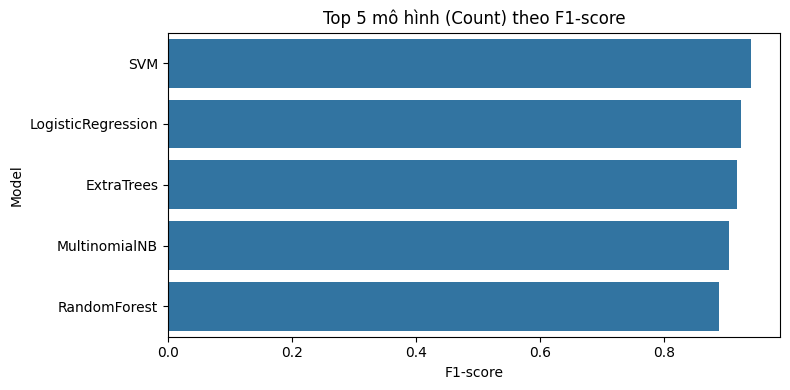


Top 5 mô hình trên TF-IDF theo F1-score:


,Model,Accuracy,Precision,Recall,F1-score
13,SVM,0.983857,1.000000,0.879195,0.935714
19,ExtraTrees,0.977578,1.000000,0.832215,0.908425
15,RandomForest,0.975785,0.991935,0.825503,0.901099
21,XGBoost,0.973991,0.976190,0.825503,0.894545
18,Bagging,0.965022,0.904412,0.825503,0.863158


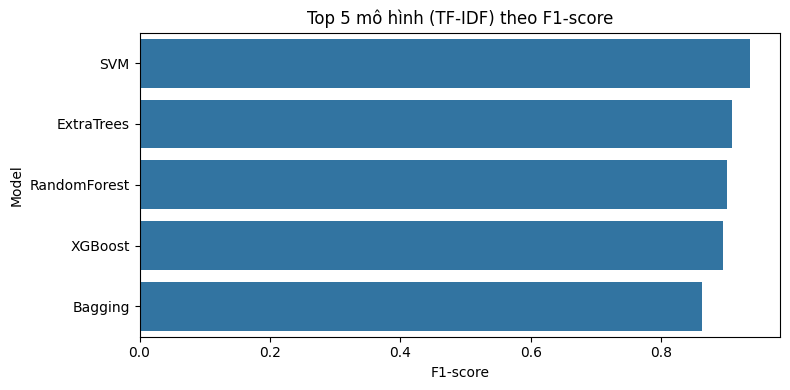

In [7]:
for feat in ['Count', 'TF-IDF']:
    df_feat=df_results[df_results['Feature']==feat]
    #lấy top 5 theo F1-score
    top5=df_feat.sort_values('F1-score', ascending=False).head(5)
    #Thể hiện biểu đồ
    print(f"\nTop 5 mô hình trên {feat} theo F1-score:")
    display(top5[['Model','Accuracy','Precision','Recall','F1-score']])
    # Vẽ barplot F1-score
    plt.figure(figsize=(8,4))
    sns.barplot(data=top5, x='F1-score', y='Model')
    plt.title(f"Top 5 mô hình ({feat}) theo F1-score")
    plt.xlabel("F1-score")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()


Confusion Matrix cho 3 model tối ưu nhất

Model: SVM trên Count (F1=0.9399)


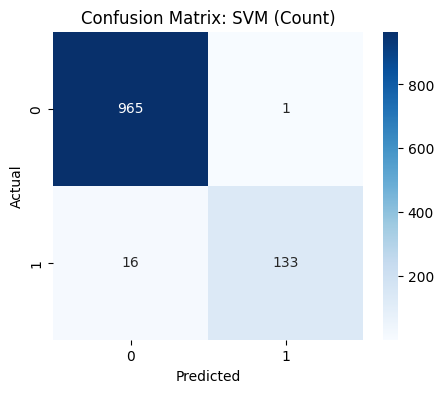

Model: SVM trên TF-IDF (F1=0.9357)


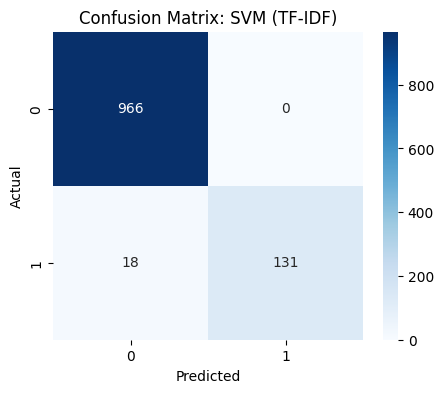

Model: LogisticRegression trên Count (F1=0.9242)


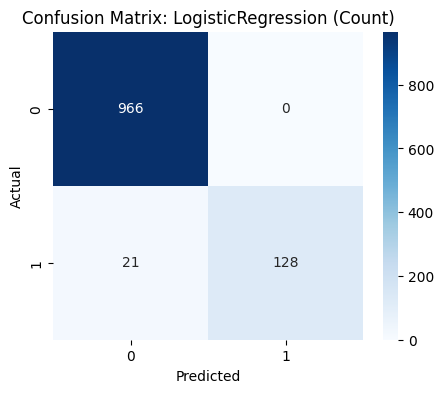

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lấy 3 mô hình tốt nhất dựa trên F1-score
top_3_rows = df_results.sort_values('F1-score', ascending=False).iloc[:3]

# Lặp qua từng mô hình trong 3 mô hình tốt nhất
for index, row in top_3_rows.iterrows():
    feat = row['Feature']  # Loại đặc trưng: 'Count' hoặc 'TF-IDF'
    model_name = row['Model']  # Tên mô hình
    print(f"Model: {model_name} trên {feat} (F1={row['F1-score']:.4f})")

    # Lấy mô hình từ dictionary models
    best_model = models[model_name]

    # Lấy tập train/test tương ứng với loại đặc trưng
    if feat == 'TF-IDF':
        X_tr, X_te, y_tr, y_te = X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test
    else:
        X_tr, X_te, y_tr, y_te = X_count_train, X_count_test, y_count_train, y_count_test

    # Huấn luyện mô hình trên tập huấn luyện
    best_model.fit(X_tr, y_tr)

    # Dự đoán trên tập kiểm tra
    y_pred = best_model.predict(X_te)

    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_te, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name} ({feat})')
    plt.show()

Lưu lại Model

In [9]:
with open('best_spam_model.pkl','wb') as f:
    pickle.dump({
        'model': best_model,
        'vectorizer': tfidf_vectorizer
    }, f)
print("Đã lưu model và vectorizer vào best_spam_model.pkl")


Đã lưu model và vectorizer vào best_spam_model.pkl
